# Setup  Directories

In [1]:
!  [ -d output ] || mkdir output ; [ -d figures ] || mkdir figures

# Load Packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from scipy.optimize import curve_fit,minimize
from glob import glob

In [3]:
def angfunk(alpha,beta,phase):
    tanhalfC=np.tan(phase*np.pi)
    halfamb=np.radians(alpha-beta)/2
    halfapb=np.radians(alpha+beta)/2
    halfAmB=np.arctan2(np.sin(halfamb),np.sin(halfapb)*tanhalfC)
    halfApB=np.arctan2(np.cos(halfamb),np.cos(halfapb)*tanhalfC)
    return (halfApB-halfAmB)

def angfunk2(alpha,beta,phase):
    a=np.radians(alpha)
    b=np.radians(beta)
    sbeta=np.sin(b)
    p=phase*2*np.pi
    return np.arctan2(sbeta*np.sin(p),(np.cos(b)*np.sin(a)-sbeta*np.cos(a)*np.cos(p)))
def costheta(alpha,beta,phase):
    a=np.radians(alpha)
    b=np.radians(beta)
    return np.cos(a)*np.cos(b)+np.sin(a)*np.sin(b)*np.cos(phase*2*np.pi) 

# Load Data

In [4]:
pislope=[0.922,0.880,0.933]
pioffset=[2.5,2.5,2.2]

In [5]:
# point this to wherever the IXPE Calb files are located -- this is on sciserver.org
CALB_DIR='/home/idies/workspace/headata/FTP/caldb/data'
OBSID='01003299'
# point this to wherever the IXPE data files are located -- this is on sciserver.org
datafile='/home/idies/workspace/headata/FTP/ixpe/data/obs/%s/%s/event_l2/ixpe%s_det?_evt2_v02.fits.gz' % (OBSID[0:2],OBSID,OBSID)
for i,f in enumerate(sorted(glob(datafile))): 
    print(i,f)
    with fits.open('%s/ixpe/gpd/cpf/modfact/ixpe_d%d_20170101_mfact_02.fits' % (CALB_DIR,i+1)) as hdu:
        modf=hdu[1].data
        modlist=np.array([m[2] for m in modf])
    with fits.open(f) as hdu:
        hdu[1].data['PI']=pislope[i]*hdu[1].data['PI']+pioffset[i]
        if (i==0):
            MJDREFI=hdu[0].header['MJDREFI']
            MJDREFF=hdu[0].header['MJDREFF']
            LIVETIME=hdu[0].header['LIVETIME']
            evtlist=hdu[1].data
            moddata=np.transpose(modlist[np.clip(hdu[1].data['PI']-25,0,len(modlist)-1)])
            detector=np.full(len(hdu[1].data),i+1)
        else:
            evtlist=np.append(evtlist,hdu[1].data)
            moddata=np.concatenate((moddata,np.transpose(modlist[np.clip(hdu[1].data['PI']-25,0,len(modlist)-1)])))
            detector=np.concatenate((detector,np.full(len(hdu[1].data),i+1)))


0 /home/idies/workspace/headata/FTP/ixpe/data/obs/01/01003299/event_l2/ixpe01003299_det1_evt2_v02.fits.gz
1 /home/idies/workspace/headata/FTP/ixpe/data/obs/01/01003299/event_l2/ixpe01003299_det2_evt2_v02.fits.gz
2 /home/idies/workspace/headata/FTP/ixpe/data/obs/01/01003299/event_l2/ixpe01003299_det3_evt2_v02.fits.gz


In [6]:
xc, yc=300, 300
for _i in range(5):
    rr=np.hypot(evtlist['X']-xc,evtlist['Y']-yc)
    ok=(evtlist['PI']>49) & (evtlist['PI']<=200) & (rr<50) 
    xc,yc=np.mean(evtlist['X'][ok]),np.mean(evtlist['Y'][ok])
    print(xc,yc)
rr=np.hypot(evtlist['X']-xc,evtlist['Y']-yc)
ok=(evtlist['PI']>49) & (evtlist['PI']<=200) & (rr<20) 
back=(evtlist['PI']>49) & (evtlist['PI']<=200) & (rr>30)  & (rr<50)
evtback=evtlist[back]
evtlist=evtlist[ok]
modback=moddata[back]
moddata=moddata[ok]
detback=detector[back]
detector=detector[ok]


301.9162 308.90826
302.0628 309.5393
302.07486 309.58224
302.07556 309.58508
302.07565 309.5853


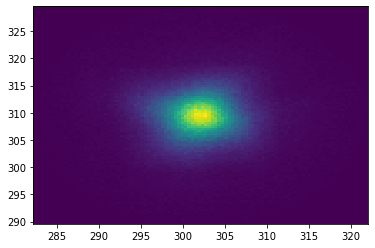

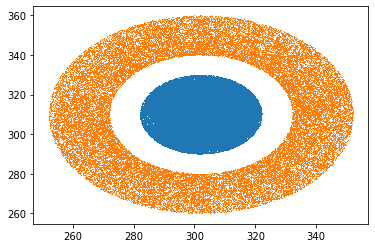

In [7]:
plt.hist2d(evtlist['X'],evtlist['Y'],bins=100)
plt.show()
plt.plot(evtlist['X'],evtlist['Y'],',')
plt.plot(evtback['X'],evtback['Y'],',')

In [8]:
pispec=np.histogram(evtlist['PI'],bins=150)[0]
np.save('output/pispec',pispec)

In [9]:
backpispec=np.histogram(evtback['PI'],bins=150)[0]*20**2/(50**2-30**2)
np.save('output/backpispec',backpispec)

In [10]:
for i in range(1,4):
    _q,_u=np.mean((evtlist['Q']/moddata)[detector==i]),np.mean((evtlist['U']/moddata)[detector==i])
    print(i,_q,_u,np.hypot(_q,_u))

1 -0.008326556622979516 0.13025225075059083 0.1305181227676466
2 -0.033718667751542857 0.1396877984431406 0.14369978980092632
3 0.0021200685450230793 0.14805136398517113 0.1480665427046408


# Barycentring

In [11]:
dobary=False
if dobary:
    pass
else:
    deltat=evtlist['TIME']-evtlist['TIME'].min()
    freqtst=1/8.68832905

# Lomb-Scargle

In [12]:
from astropy.timeseries import LombScargle
ls = LombScargle(deltat,np.ones(len(deltat)))
lsu = LombScargle(deltat,evtlist['U']*moddata)
lsq = LombScargle(deltat,evtlist['Q']*moddata)

In [13]:
freqq,powerq = lsq.autopower(minimum_frequency=freqtst*0.99,maximum_frequency=freqtst*1.01,samples_per_peak=50)
frequ,poweru = lsu.autopower(minimum_frequency=freqtst*0.99,maximum_frequency=freqtst*1.01,samples_per_peak=50)

In [14]:
freq,power = ls.autopower(minimum_frequency=freqtst*0.99,maximum_frequency=freqtst*1.01,samples_per_peak=50)
freqmax=freq[np.argmax(power)]
print(freqmax,freqmax-freqtst)

0.11507140684724751 -2.5523096951599045e-05


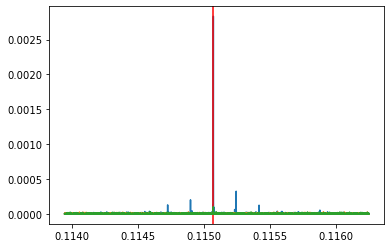

In [15]:
plt.plot(freq,power)
plt.axvline(freqmax,c='r')
plt.plot(frequ,poweru)
plt.plot(freqq,powerq)

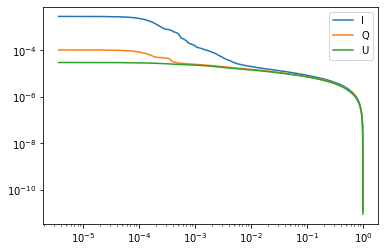

In [16]:
plt.loglog(np.linspace(1,len(power),len(power))/len(power),-np.sort(-power),label='I')
plt.loglog(np.linspace(1,len(powerq),len(powerq))/len(powerq),-np.sort(-powerq),label='Q')
plt.loglog(np.linspace(1,len(poweru),len(poweru))/len(poweru),-np.sort(-poweru),label='U')
plt.legend()

In [17]:
_dt=deltat
def calcppow(xx,kmax=2):
    _fff=xx[0]
    _fdf=xx[1]
    phase=2*np.pi*(_dt*(_fff+_dt*_fdf*0.5))
    if kmax>1:
        sphase=np.sin(phase)
        cphase=np.cos(phase)
        snphase=sphase
        cnphase=cphase
        pppow=np.sum(snphase)**2+np.sum(cnphase)**2
        for _j in range(2,kmax+1):
            _snphase=snphase*cphase+cnphase*sphase
            cnphase=cnphase*cphase-snphase*sphase
            snphase=_snphase
            pppow+=np.sum(snphase)**2+np.sum(cnphase)**2
    else:
        pppow=np.sum(np.sin(phase))**2+np.sum(np.cos(phase))**2
    return(-pppow)  

In [18]:
print(calcppow([freqmax,-3e-15]))
respow=minimize(calcppow,[freqmax,-3e-15],method='Nelder-Mead')
print(respow.fun,respow.x)
respow=minimize(calcppow,respow.x)
print(respow.fun,respow.x)

-872567052.6038213
-883575605.7365899 [1.15071338e-01 4.94331185e-14]
-883575605.7365899 [1.15071338e-01 4.94331185e-14]


In [19]:
print(freqmax,respow.x)

0.11507140684724751 [1.15071338e-01 4.94331185e-14]


# Folding

0.11967031225233793


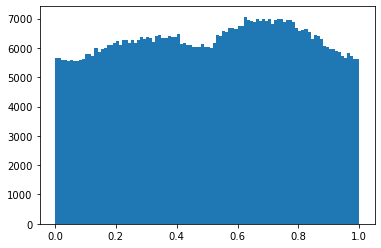

In [20]:
phdata=np.mod(deltat*(respow.x[0]+_dt*respow.x[1]*0.5),1)
toton=plt.hist(phdata,bins=100)
print((toton[0].max()-toton[0].min())/(toton[0].max()+toton[0].min()))

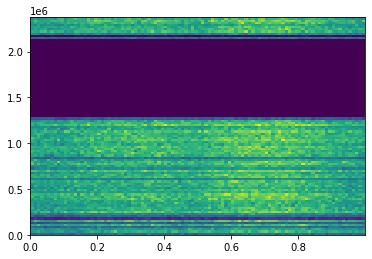

In [21]:
bindata=plt.hist2d(phdata,deltat,bins=100)

# Unbinned Likelihood Analysis

In [22]:
qdata=evtlist['Q']*moddata
udata=evtlist['U']*moddata

def maxlikephase(param):
    for _i in range(len(param)//2):
        qloc[_i]=np.cos(2*param[2*_i])*np.tanh(param[2*_i+1])
        uloc[_i]=np.sin(2*param[2*_i])*np.tanh(param[2*_i+1])
#        qloc[_i]=param[2*_i]
#        uloc[_i]=param[2*_i+1]

    return(-np.sum(np.log(1+0.5*(qloc[phbin]*qdata+uloc[phbin]*udata))))

def maxlikephaseok(param,_phb,_qd,_ud):
    for _i in range(len(param)//2):
        qloc[_i]=np.cos(2*param[2*_i])*np.tanh(param[2*_i+1])
        uloc[_i]=np.sin(2*param[2*_i])*np.tanh(param[2*_i+1])
#        qloc[_i]=param[2*_i]
#        uloc[_i]=param[2*_i+1]

    return(-np.sum(np.log(1+0.5*(qloc[_phb]*_qd+uloc[_phb]*_ud))))


def maxlikephasequ(param):
    for _i in range(len(param)//2):
        qloc[_i]=np.tanh(param[2*_i])
        uloc[_i]=np.tanh(param[2*_i+1])
#        qloc[_i]=param[2*_i]
#        uloc[_i]=param[2*_i+1]

    return(-np.sum(np.log(1+0.5*(qloc[phbin]*qdata+uloc[phbin]*udata))))

def maxlikefixed(param):
    qloc=param[0]
    uloc=param[1]
    norm=np.hypot(qloc,uloc)
    if norm>1:
        qloc/=norm
        uloc/=norm
    
    return(-np.sum(np.log(1+0.5*(qloc*qdata+uloc*udata))))

def maxlikerotation(param):
    ang=angfunk(param[1],param[2],phdata-param[4])+np.radians(param[3])
    qloc=np.cos(2*ang)*np.tanh(param[0])
    uloc=np.sin(2*ang)*np.tanh(param[0])
    if (len(param)>5):
        qloc+=np.tanh(param[5])
        uloc+=np.tanh(param[6])
    _res=-np.sum(np.log(1+0.5*(qloc*qdata+uloc*udata)))
    # print(_res,param)
    return _res
def maxlikerotation_rand(param):
    ang=angfunk(param[1],param[2],phdata-param[4])+np.radians(param[3])
    qloc=np.cos(2*ang)*np.tanh(param[0])
    uloc=np.sin(2*ang)*np.tanh(param[0])
    if (len(param)>5):
        qloc+=np.tanh(param[5])
        uloc+=np.tanh(param[6])
    return(-np.sum(np.log(1+0.5*(qloc*qrand+uloc*urand))))
def maxlikerotation2(param):
    ang=angfunk(param[1],param[2],phdata-param[4])+np.radians(param[3])
    qloc=np.cos(2*ang)
    uloc=np.sin(2*ang)
    polfrac=np.tanh(param[0])
    if (len(param)>5):
        polfrac*=(1+param[5]*np.cos(2*np.pi*(phdata-param[6])))
    qloc*=polfrac
    uloc*=polfrac
    if (len(param)>7):
        qloc+=np.tanh(param[7])
        uloc+=np.tanh(param[8])        
    return(-np.sum(np.log(1+0.5*(qloc*qdata+uloc*udata))))
def maxlikerotation2_ok(param,_phd,_qd,_ud):
    ang=angfunk(param[1],param[2],_phd-param[4])+np.radians(param[3])
    qloc=np.cos(2*ang)
    uloc=np.sin(2*ang)
    polfrac=np.tanh(param[0])
    if (len(param)>5):
        polfrac*=(1+param[5]*np.cos(2*np.pi*(_phd-param[6])))
    qloc*=polfrac
    uloc*=polfrac
    if (len(param)>7):
        qloc+=np.tanh(param[7])
        uloc+=np.tanh(param[8]) 
    return(-np.sum(np.log(1+0.5*(qloc*_qd+uloc*_ud))))
def maxlikerotation2frac(param):
    ang=angfunk(param[1],param[2],phdata-param[4])+np.radians(param[3]+param[4]*tdata)
    qloc=np.cos(2*ang)
    uloc=np.sin(2*ang)
    polfrac=np.tanh(param[0])
    if (len(param)>5):
        polfrac*=(1+param[5]*np.cos(2*np.pi*(phdata-param[6])))
    qloc*=polfrac
    uloc*=polfrac
    if (len(param)>7):
        qloc+=np.tanh(param[7])
        uloc+=np.tanh(param[8])        
    return(-np.sum(np.log(1+0.5*(qloc*qdata+uloc*udata))))

In [23]:
np.savetxt('output/photondata.txt',[phdata,qdata,udata])

In [24]:
ppp_fixed=minimize(maxlikefixed,np.random.normal(size=2)*np.array([0.3,0.3]),method='Nelder-Mead')
ppp_fixed

 final_simplex: (array([[-0.01504553,  0.12633103],
       [-0.0149832 ,  0.12636784],
       [-0.01509376,  0.12638505]]), array([-158.32516706, -158.32516114, -158.32514785]))
           fun: -158.32516706120276
       message: 'Optimization terminated successfully.'
          nfev: 73
           nit: 38
        status: 0
       success: True
             x: array([-0.01504553,  0.12633103])

In [25]:
ppp_rot=minimize(maxlikerotation2,np.random.normal(size=5)*np.array([0.1,50,50,90,1]),method='Nelder-Mead')
if (ppp_rot.x[0]<0):
    ppp_rot.x[0]*=-1
    ppp_rot.x[3]+=90
ppp_rot

 final_simplex: (array([[  0.13855558,  26.74744608,   6.47426011,  48.06295822,
          0.46338676],
       [ -0.13855567,  26.74737395,   6.47425378, -41.93707875,
          0.46338581],
       [ -0.13855561,  26.74740899,   6.47424423, -41.93703414,
          0.46338576],
       [ -0.13855588,  26.74746028,   6.47426349, -41.93703574,
          0.4633862 ],
       [ -0.13855592,  26.74745379,   6.47429421, -41.93706951,
          0.46338587],
       [ -0.13855586,  26.747383  ,   6.47422986, -41.93707592,
          0.46338675]]), array([-185.19812914, -185.19812914, -185.19812914, -185.19812914,
       -185.19812914, -185.19812914]))
           fun: -185.19812914444978
       message: 'Optimization terminated successfully.'
          nfev: 732
           nit: 436
        status: 0
       success: True
             x: array([ 0.13855558, 26.74744608,  6.47426011, 48.06295822,  0.46338676])

In [26]:
ppp_rot2=minimize(maxlikerotation2,np.concatenate((ppp_rot.x,np.random.normal(size=2))),method='Nelder-Mead')
ppp_rot2

 final_simplex: (array([[ 1.39391109e-01,  1.89029268e+02, -2.42869374e+00,
         4.76700588e+01,  4.39960094e-01, -1.74470499e-01,
        -3.99472610e-02],
       [ 1.39380267e-01,  1.89057786e+02, -2.43616294e+00,
         4.76642939e+01,  4.40047462e-01, -1.74287781e-01,
        -3.97949881e-02],
       [ 1.39356488e-01,  1.88998452e+02, -2.41865121e+00,
         4.76635359e+01,  4.39944222e-01, -1.74042272e-01,
        -3.97832495e-02],
       [ 1.39373140e-01,  1.88883115e+02, -2.38827082e+00,
         4.76617856e+01,  4.40005185e-01, -1.74411396e-01,
        -3.99754698e-02],
       [ 1.39373768e-01,  1.89036239e+02, -2.42961000e+00,
         4.76672110e+01,  4.40052645e-01, -1.74118948e-01,
        -3.97501227e-02],
       [ 1.39357504e-01,  1.89046114e+02, -2.43176533e+00,
         4.76703552e+01,  4.40068078e-01, -1.74355978e-01,
        -3.98501794e-02],
       [ 1.39367214e-01,  1.88988571e+02, -2.41640884e+00,
         4.76619313e+01,  4.39928750e-01, -1.74404758e-01,
 

In [27]:
ppp_rot=minimize(maxlikerotation2,ppp_rot2.x[0:-2],method='Nelder-Mead')
ppp_rot

 final_simplex: (array([[ 1.39254463e-01,  1.80000103e+02, -2.85501962e-05,
         4.76647273e+01,  4.33985483e-01],
       [ 1.39254460e-01,  1.80000175e+02, -4.83549496e-05,
         4.76647250e+01,  4.33985520e-01],
       [ 1.39254457e-01,  1.80000159e+02, -4.39158006e-05,
         4.76647250e+01,  4.33985489e-01],
       [ 1.39254469e-01,  1.80000191e+02, -5.28268430e-05,
         4.76647250e+01,  4.33985484e-01],
       [ 1.39254458e-01,  1.80000075e+02, -2.05744658e-05,
         4.76647222e+01,  4.33985528e-01],
       [ 1.39254458e-01,  1.80000203e+02, -5.61168746e-05,
         4.76647246e+01,  4.33985503e-01]]), array([-187.10262153, -187.10262153, -187.10262153, -187.10262153,
       -187.10262153, -187.10262153]))
           fun: -187.10262153384033
       message: 'Optimization terminated successfully.'
          nfev: 654
           nit: 397
        status: 0
       success: True
             x: array([ 1.39254463e-01,  1.80000103e+02, -2.85501962e-05,  4.76647273e+01,
 

# Binned Analysis

In [28]:
qloc=np.zeros(10)
uloc=np.zeros(10)
phbin=(phdata//0.1).astype(int)
gogo=True
while gogo:
    ppp_phase=minimize(maxlikephase,np.random.uniform(size=20))
    gogo=(ppp_phase.success==False)
ppp_phase_err=np.diag(ppp_phase.hess_inv)**0.5    

In [29]:
ppp_phasequ=minimize(maxlikephasequ,(np.arange(20)+1)*0.2)
ppp_phasequ_err=np.diag(ppp_phasequ.hess_inv)**.5

In [30]:
tt=np.sum(toton[0].reshape((10,10)),axis=1)
phlist=np.linspace(0.05,0.95,10)
with open('output/QU_phase.dat','w') as f:
    print('#    Phase        Q/I       EQ/I        U/I       EU/I     Counts')
    f.write('#    Phase        Q/I       EQ/I        U/I       EU/I     Counts\n')

    for r in zip(phlist,np.tanh(ppp_phasequ.x[::2]),np.diag(ppp_phasequ.hess_inv)[::2]**0.5/np.cosh(ppp_phasequ.x[::2])**2,
                 np.tanh(ppp_phasequ.x[1::2]),np.diag(ppp_phasequ.hess_inv)[1::2]**0.5/np.cosh(ppp_phasequ.x[1::2])**2,tt):
        print(('%10g '*6) % r)
        f.write((('%10g '*6) % r)+'\n')

#    Phase        Q/I       EQ/I        U/I       EU/I     Counts
      0.05  0.0232109  0.0316559  0.0981404  0.0206966      56002 
      0.15  0.0492221  0.0442807   0.160622  0.0229847      59441 
      0.25  0.0612384  0.0230481   0.140653  0.0260938      62404 
      0.35  0.0187369  0.0230238   0.166311  0.0263777      63583 
      0.45 0.00836049  0.0299079   0.112319  0.0212535      61264 
      0.55 -0.0707986  0.0247261   0.139716  0.0224373      64133 
      0.65 -0.0769665  0.0293784   0.161631  0.0215526      69157 
      0.75 -0.0969225  0.0223241  0.0973667  0.0224716      69097 
      0.85 -0.0720727  0.0284601  0.0878819  0.0340945      63977 
      0.95   0.038417  0.0285871  0.0966112  0.0211749      57851 


In [31]:
with open('output/pol_phase.dat','w') as f:
    print('#    Phase         PD        EPD         PA        EPA     Counts')
    f.write('#    Phase         PD        EPD         PA        EPA     Counts\n')
    for r in zip((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.abs(np.tanh(ppp_phase.x[1::2])),ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2])**2,np.mod(np.degrees(np.where(ppp_phase.x[1::2]>0,0,np.pi*0.5)+ppp_phase.x[::2]),180),
        np.degrees(ppp_phase_err[::2]),tt):
        print('%10g '*6 %r)
        f.write(('%10g '*6 %r)+'\n')
        

#    Phase         PD        EPD         PA        EPA     Counts
      0.05   0.100848  0.0227155    38.3468    7.08386      56002 
      0.15   0.167995  0.0223917    36.4812     3.8662      59441 
      0.25   0.153406  0.0226831    33.2362    4.04621      62404 
      0.35   0.167363  0.0224743     41.786    3.87052      63583 
      0.45    0.11263  0.0224627    42.8715    5.92853      61264 
      0.55    0.15663  0.0229506    58.4364    3.91032      64133 
      0.65   0.179021  0.0218676    57.7316    3.24683      69157 
      0.75   0.137384  0.0214266    67.4345    4.39044      69097 
      0.85   0.113656  0.0216543    64.6777    5.50904      63977 
      0.95   0.103969  0.0227474    34.1575    6.49492      57851 


Text(0, 0.5, 'U/I')

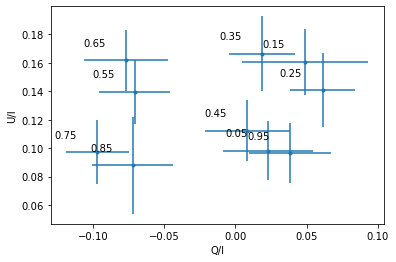

In [32]:
#plt.figure(figsize=(6,4))
plt.gca().set_aspect('equal')
plt.errorbar(np.tanh(ppp_phasequ.x[::2]),np.tanh(ppp_phasequ.x[1::2]),yerr=np.diag(ppp_phasequ.hess_inv)[1::2]**0.5/np.cosh(ppp_phasequ.x[1::2])**2,xerr=np.diag(ppp_phasequ.hess_inv)[::2]**0.5/np.cosh(ppp_phasequ.x[::2])**2,fmt='.')
for _xx,_yy,_tt in zip(np.tanh(ppp_phasequ.x[::2]),np.tanh(ppp_phasequ.x[1::2]),np.linspace(0.05,0.95,10)):
    plt.text(_xx-3e-2,_yy+1e-2,'%.2f' % _tt)
plt.xlabel('Q/I')
plt.ylabel('U/I')

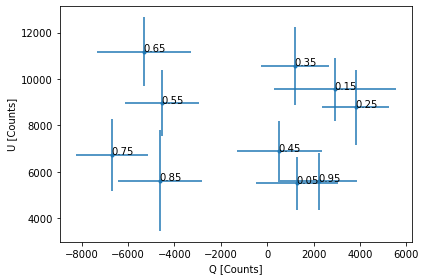

In [33]:
#plt.figure(figsize=(7,4))
plt.gca().set_aspect('equal')
plt.errorbar(np.tanh(ppp_phasequ.x[::2])*tt,np.tanh(ppp_phasequ.x[1::2])*tt,yerr=tt*np.diag(ppp_phasequ.hess_inv)[1::2]**0.5/np.cosh(ppp_phasequ.x[1::2])**2,xerr=tt*np.diag(ppp_phasequ.hess_inv)[::2]**0.5/np.cosh(ppp_phasequ.x[::2])**2,fmt='.')
for _xx,_yy,_tt,_qq in zip(np.tanh(ppp_phasequ.x[::2])*tt,np.tanh(ppp_phasequ.x[1::2])*tt,phlist,tt):
    plt.text(_xx-3e+1,_yy+1e+1,'%.2f' % (_tt))
param=ppp_rot2.x
ang=angfunk(param[1],param[2],phlist-param[4])+np.radians(param[3])
polfrac=np.tanh(param[0])
if (len(param)>5):
    polfrac*=(1+param[5]*np.cos(2*np.pi*(phlist-param[6])))

qloc=np.cos(2*ang)*polfrac*60000
uloc=np.sin(2*ang)*polfrac*60000
#plt.plot(qloc,uloc)  
#plt.xlim(-18000,5000)
#plt.ylim(0,12000)
#plt.ylim(-0.1,0.3)
plt.xlabel('Q [Counts]')
plt.ylabel('U [Counts]')
plt.tight_layout()
plt.savefig('figures/QU.pdf')

# Plots

In [34]:
def plottwo(x,y,yerr,fmt):
    _x=np.concatenate((x,x+1))
    _y=np.concatenate((y,y))
    _yerr=np.concatenate((yerr,yerr))
    plt.errorbar(_x,_y,xerr=(_x[1]-_x[0])/2,yerr=_yerr,fmt=fmt)

In [35]:
def cfunk(p,a,b,c):
    return(a*np.cos((p-b)*2*np.pi)+c)

cfit=curve_fit(cfunk,0.5*toton[1][:-1]+0.5*toton[1][1:],toton[0],sigma=(toton[0])**0.5)
pfit=curve_fit(cfunk,(np.arange(len(ppp_phase.x)//2)+0.5)/10,100*np.abs(np.tanh(ppp_phase.x[1::2])),sigma=100*ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2])**2)

0.11967031225233793


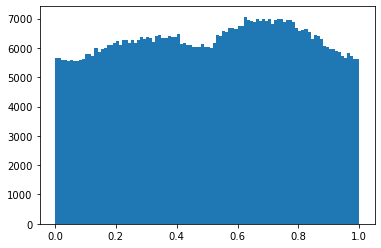

In [36]:
toton=plt.hist(phdata,bins=100)
print((toton[0].max()-toton[0].min())/(toton[0].max()+toton[0].min()))

0.11967031225233793 -0.07482682852851487


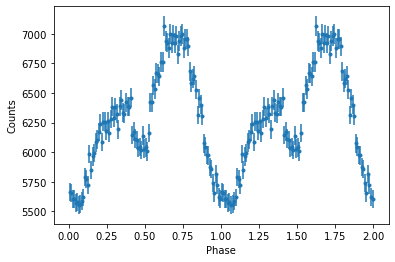

In [37]:

_ph=np.linspace(0,2,201)
plottwo(0.5*toton[1][:-1]+0.5*toton[1][1:],toton[0],(toton[0])**0.5,'.')
#plt.plot(_ph,cfunk(_ph,*cfit[0]))
plt.ylabel('Counts')
plt.xlabel('Phase')
print((toton[0].max()-toton[0].min())/(toton[0].max()+toton[0].min()),cfit[0][0]/cfit[0][2])
plt.savefig('figures/intensity.pdf')

0.13929014966290582 0.00713788746660365


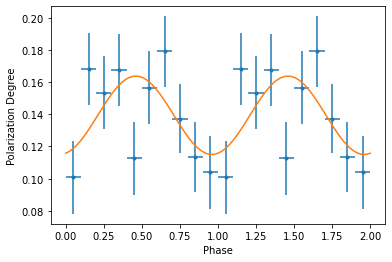

In [38]:
plottwo((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.abs(np.tanh(ppp_phase.x[1::2])),ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2])**2,'.')
#plt.plot(_ph,cfunk(_ph,*pfit[0])/100)
plt.plot(_ph,np.abs(ppp_rot2.x[0]*(1+ppp_rot2.x[5]*np.cos(2*np.pi*(_ph-ppp_rot2.x[6])))))
plt.ylabel('Polarization Degree')
plt.xlabel('Phase')
plt.savefig('figures/polar-deg.pdf')
print(np.mean(np.abs(np.tanh(ppp_phase.x[1::2]))),np.sum((ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2]))**2)**0.5/10)


Alpha:                      9.02927
Beta:                       -2.42869
Mean Polarization Fraction: 0.138495
Ampl Polarization Fraction: 0.0241633
Peak Polarization Fraction: 0.960053
Pole across Line of Sight:  0.93996
Peak Flux:                  0.621717


Alpha:                      0.000103414
Beta:                       -2.85502e-05
Mean Polarization Fraction: 0.138361
Pole across Line of Sight:  0.933985
Peak Flux:                  0.621717



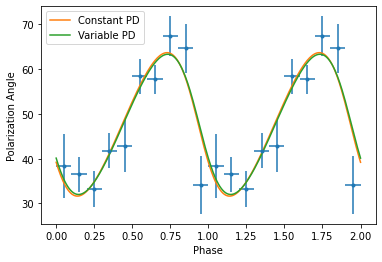

In [39]:
shift=0
plottwo((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.mod(np.degrees(np.where(ppp_phase.x[1::2]>0,0,np.pi*0.5)+ppp_phase.x[::2])-shift,180)+shift,np.degrees(ppp_phase_err[::2]),'.')
_ph=np.linspace(0,2,401)
print('''
Alpha:                      %g
Beta:                       %g
Mean Polarization Fraction: %g
Ampl Polarization Fraction: %g
Peak Polarization Fraction: %g
Pole across Line of Sight:  %g
Peak Flux:                  %g
''' % ((ppp_rot2.x[1]%180,ppp_rot2.x[2])+tuple(np.mod(np.array([np.abs(np.tanh(ppp_rot2.x[0])),np.abs(ppp_rot2.x[5]*np.tanh(ppp_rot2.x[0])),
                                                            ppp_rot2.x[6],
                                                            ppp_rot2.x[4]+(0 if ppp_rot2.x[2]>0 else 0.5),
                                                            (cfit[0][1] if cfit[0][0]>0 else cfit[0][1]-0.5)]),1))))
print('''
Alpha:                      %g
Beta:                       %g
Mean Polarization Fraction: %g
Pole across Line of Sight:  %g
Peak Flux:                  %g
''' % (ppp_rot.x[1]%180,ppp_rot.x[2],np.abs(np.tanh(ppp_rot.x[0])),np.mod(ppp_rot.x[4]+(0 if ppp_rot.x[2]>0 else 0.5),1),
                                                            np.mod(cfit[0][1] if cfit[0][0]>0 else cfit[0][1]-0.5,1)))

if ppp_rot.x[0]>0:
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot.x[1],ppp_rot.x[2],_ph-ppp_rot.x[4])+np.radians(ppp_rot.x[3]-shift)),np.pi))+shift,label='Constant PD')
else:
    plt.plot(_ph,np.degrees(np.mod(np.pi/2+(angfunk(ppp_rot.x[1],ppp_rot.x[2],_ph-ppp_rot.x[4])+np.radians(ppp_rot.x[3]-shift)),np.pi))+shift,label='Constant PD')

if ppp_rot2.x[0]>0:
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot2.x[1],ppp_rot2.x[2],_ph-ppp_rot2.x[4])+np.radians(ppp_rot2.x[3]-shift)),np.pi))+shift,label='Variable PD')
else:
    plt.plot(_ph,np.degrees(np.mod(np.pi/2+(angfunk(ppp_rot2.x[1],ppp_rot2.x[2],_ph-ppp_rot2.x[4])+np.radians(ppp_rot2.x[3]-shift)),np.pi))+shift,label='Variable PD')

#plt.ylim(25,75)
plt.ylabel('Polarization Angle')
plt.xlabel('Phase')
plt.legend()
plt.savefig('figures/polar-angle.pdf')

# Energy Dependence

In [40]:
pibin=np.clip(((evtlist['PI']-50)//25).astype(int),0,4)
def maxlikeenergy(param):
    return(-np.sum(np.log(1+0.5*(np.tanh(param[2*pibin])*qrot+np.tanh(param[2*pibin+1])*urot))))
def maxlikeenergy2(param):
    return(-np.sum(np.log(1+0.5*(np.tanh(param[pibin])*qrot))))


In [41]:
angdata=angfunk( ppp_rot.x[1],  ppp_rot.x[2], phdata-ppp_rot.x[4])+np.radians(ppp_rot.x[3])

sangdata=np.sin(2*angdata)
cangdata=np.cos(2*angdata)
urot=evtlist['U']*cangdata-evtlist['Q']*sangdata
qrot=evtlist['U']*sangdata+evtlist['Q']*cangdata
um,qm=np.mean(urot/moddata),np.mean(qrot/moddata)
print(um,qm,np.hypot(um,qm),np.std(qrot/moddata)/len(qrot)**0.5,np.std(qrot)/np.mean(moddata)/len(qrot)**0.5)
urot*=moddata
qrot*=moddata

-0.002827039344737846 0.15403032563160673 0.15405626688205679 0.00856939018973331 0.007463929468592541


In [42]:
ppp_spec_deg=minimize(maxlikeenergy2,np.random.uniform(size=5)-0.5)

In [43]:
ppp_spec_qu=minimize(maxlikeenergy,np.random.uniform(size=10)-0.5)

Text(0, 0.5, 'U/I')

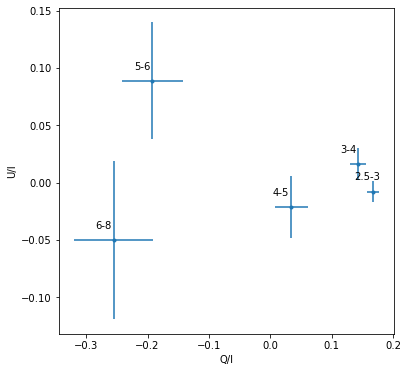

In [44]:
plt.figure(figsize=(6,6))
plt.errorbar(np.tanh(ppp_spec_qu.x[::2]),np.tanh(ppp_spec_qu.x[1::2]),yerr=np.diag(ppp_spec_qu.hess_inv)[1::2]**0.5/np.cosh(ppp_spec_qu.x[1::2])**2,xerr=np.diag(ppp_spec_qu.hess_inv)[::2]**0.5/np.cosh(ppp_spec_qu.x[::2])**2,fmt='.')
for _xx,_yy,_tt in zip(np.tanh(ppp_spec_qu.x[::2]),np.tanh(ppp_spec_qu.x[1::2]),['2.5-3','3-4','4-5','5-6','6-8']):
    plt.text(_xx-3e-2,_yy+1e-2,_tt)
#plt.xlim(-0.29,0.29)
#plt.ylim(-0.29,0.29)
plt.xlabel('Q/I')
plt.ylabel('U/I')

Text(0, 0.5, 'Q/I')

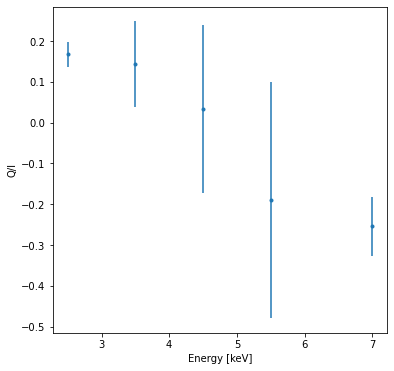

In [45]:
plt.figure(figsize=(6,6))
_xxx=[2.5,3.5,4.5,5.5,7]
plt.errorbar(_xxx,np.tanh(ppp_spec_deg.x),yerr=np.diag(ppp_spec_deg.hess_inv)**0.5/np.cosh(ppp_spec_deg.x)**2,fmt='.')
plt.xlabel('Energy [keV]')
plt.ylabel('Q/I')

# Bin optimization

In [46]:
_ii=np.argsort(evtlist['PI'])
pisort=evtlist['PI'][_ii]
modsort=moddata[_ii]

In [47]:
modcum=np.cumsum(modsort)
def mdpfunk(imin,imax):
    return(4.29/((modcum[imax]-modcum[imin])/(imax-imin))/(imax-imin)**0.5)
def mdppi(pimin,pimax):
    _imin=np.interp(pimin,pisort,range(len(pisort))).astype(int)
    _imax=np.interp(pimax,pisort,range(len(pisort))).astype(int)

    return mdpfunk(_imin,_imax)

In [48]:
modscum=np.cumsum(modsort**2)

In [49]:
plist=np.interp(np.linspace(0,1,70),modscum/modscum[-1],np.arange(len(modcum))).astype(int)
plist

array([     0,  29972,  57711,  82745, 105577, 126696, 146210, 164171,
       181992, 198274, 213889, 228767, 243207, 256956, 269902, 282533,
       294337, 306161, 317243, 328089, 338419, 348423, 358183, 367457,
       376617, 385545, 394285, 402628, 410837, 418742, 426605, 434168,
       441604, 448818, 455834, 462725, 469389, 475930, 482395, 488705,
       494889, 500949, 506906, 512729, 518433, 523961, 529380, 534707,
       539996, 545186, 550256, 555204, 560055, 564809, 569471, 574060,
       578556, 582962, 587266, 591508, 595654, 599706, 603645, 607486,
       611235, 614844, 618293, 621536, 624477, 626908])

In [50]:
for ii in range(len(plist)-1):
    _imin=plist[ii]
    _imax=plist[ii+1]
    _pmin,_pmax=pisort[_imin],pisort[_imax]
    # print(ii,_pmin,_pmax,_pmin/25,_pmax/25,mdpfunk(plist[ii],plist[ii+1]))

In [51]:
pilist=np.concatenate((pisort[plist[0:65:5]],pisort[plist[65:]]))
elist=pilist/25

In [52]:
pibin=np.digitize(evtlist['PI'],pilist)-1
pibin.min(),pibin.max()

(0, 17)

In [53]:
ppp_spec_deg=minimize(maxlikeenergy2,np.random.uniform(size=pibin.max()+1)-0.5)

In [54]:
ppp_spec_qu=minimize(maxlikeenergy,np.random.uniform(size=2*pibin.max()+2)-0.5)

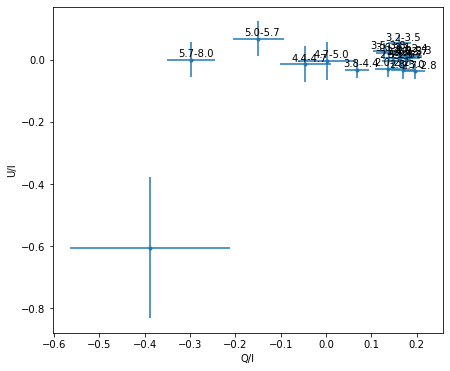

In [55]:
plt.figure(figsize=(7,6))
plt.errorbar(np.tanh(ppp_spec_qu.x[::2]),np.tanh(ppp_spec_qu.x[1::2]),yerr=np.diag(ppp_spec_qu.hess_inv)[1::2]**0.5/np.cosh(ppp_spec_qu.x[1::2])**2,xerr=np.diag(ppp_spec_qu.hess_inv)[::2]**0.5/np.cosh(ppp_spec_qu.x[::2])**2,fmt='.')
for _xx,_yy,_e0,_e1 in zip(np.tanh(ppp_spec_qu.x[::2]),np.tanh(ppp_spec_qu.x[1::2]),elist[:-1],elist[1:]):
    plt.text(_xx-3e-2,_yy+1e-2,'%.1f-%.1f' % (_e0,_e1))
#plt.xlim(-0.4,0.3)
#plt.ylim(-0.3,0.3)
plt.xlabel('Q/I')
plt.ylabel('U/I')
plt.savefig('figures/QU-energy_v1.pdf')

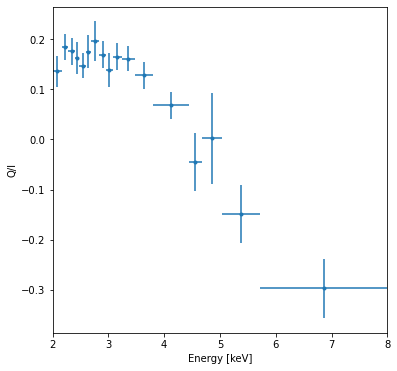

In [56]:
plt.figure(figsize=(6,6))

plt.errorbar(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_deg.x)[:-1],
             yerr=(np.diag(ppp_spec_deg.hess_inv)**0.5/np.cosh(ppp_spec_deg.x)**2)[:-1],
             xerr=0.5*(-elist[:-1]+elist[1:]),fmt='.')
plt.xlim(2,8)

plt.xlabel('Energy [keV]')
plt.ylabel('Q/I')
plt.savefig('figures/polar-energy.pdf')
np.save('output/qoveri',[0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_deg.x)[:-1],
             (np.diag(ppp_spec_deg.hess_inv)**0.5/np.cosh(ppp_spec_deg.x)**2)[:-1],
             0.5*(-elist[:-1]+elist[1:])])

In [57]:
with open('output/poldeg_energy.dat','w') as f:
    print('#     Emid        Q/I       EQ/I   DeltaE/2')
    f.write('#     Emid        Q/I       EQ/I   DeltaE/2\n')

    for r in zip(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_deg.x)[:-1],
                 (np.diag(ppp_spec_deg.hess_inv)**0.5/np.cosh(ppp_spec_deg.x)**2)[:-1],
                 0.5*(-elist[:-1]+elist[1:])):
        print(('%10g '*4) % r)
        f.write((('%10g '*4) % r)+'\n')

#     Emid        Q/I       EQ/I   DeltaE/2
      2.08    0.13583  0.0312709       0.08 
      2.22   0.184655   0.026715       0.06 
      2.34   0.175927  0.0271412       0.06 
      2.44   0.162578   0.031974       0.04 
      2.54   0.147628  0.0245567       0.06 
      2.64   0.175489  0.0326723       0.04 
      2.76   0.195694  0.0398634       0.08 
       2.9   0.169422  0.0266897       0.06 
      3.02    0.13858  0.0346505       0.06 
      3.16   0.165487  0.0266596       0.08 
      3.36   0.161584   0.025506       0.12 
      3.64   0.127873  0.0267702       0.16 
      4.12   0.068195  0.0272865       0.32 
      4.56 -0.0455557  0.0581798       0.12 
      4.86 0.00222513  0.0910781       0.18 
      5.38  -0.148849  0.0582459       0.34 
      6.86  -0.297184  0.0591359       1.14 


In [58]:
with open('output/QU_energy.dat','w') as f:
    print('#    Emid         Q/I       EQ/I        U/I       EU/I   DeltaE/2')
    f.write('#    Emid         Q/I       EQ/I        U/I       EU/I   DeltaE/2\n')

    for r in zip(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_qu.x[::2]),np.diag(ppp_spec_qu.hess_inv)[::2]**0.5/np.cosh(ppp_spec_qu.x[::2])**2,
                 np.tanh(ppp_spec_qu.x[1::2]),np.diag(ppp_spec_qu.hess_inv)[1::2]**0.5/np.cosh(ppp_spec_qu.x[1::2])**2,
                0.5*(-elist[:-1]+elist[1:])):
        print(('%10g '*6) % r)
        f.write((('%10g '*6) % r)+'\n')

#    Emid         Q/I       EQ/I        U/I       EU/I   DeltaE/2
      2.08   0.135776  0.0276744 -0.0283648  0.0271939       0.08 
      2.22    0.18467  0.0266544  0.0107448  0.0273325       0.06 
      2.34   0.175899  0.0257101  0.0161348  0.0262835       0.06 
      2.44   0.162576  0.0297376 0.00625555  0.0303265       0.04 
      2.54   0.147629  0.0238721 -0.00289712  0.0253668       0.06 
      2.64   0.175478   0.031021 0.00616175  0.0311963       0.04 
      2.76   0.195568  0.0234401 -0.0367363  0.0245135       0.08 
       2.9   0.169403  0.0271022 -0.0338477  0.0268945       0.06 
      3.02   0.138505  0.0284327  0.0207518  0.0270321       0.06 
      3.16   0.165479  0.0264198 -0.00241091  0.0259976       0.08 
      3.36    0.16132  0.0252526  0.0527699  0.0256325       0.12 
      3.64   0.127802  0.0251478  0.0276232  0.0259479       0.16 
      4.12  0.0680887  0.0260036 -0.0321998  0.0258226       0.32 
      4.56 -0.0455794   0.055563 -0.0138276  0.0567117       

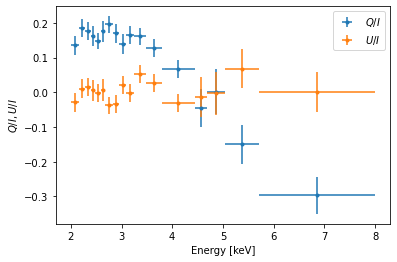

In [59]:
plt.errorbar(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_qu.x)[:-2:2],
             yerr=(np.diag(ppp_spec_qu.hess_inv)**0.5/np.cosh(ppp_spec_qu.x)**2)[:-2:2],
             xerr=0.5*(-elist[:-1]+elist[1:]),fmt='.',label=r'$Q/I$')
plt.errorbar(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_qu.x)[1:-1:2],
             yerr=(np.diag(ppp_spec_qu.hess_inv)**0.5/np.cosh(ppp_spec_qu.x)**2)[1:-1:2],
             xerr=0.5*(-elist[:-1]+elist[1:]),fmt='.',label=r'$U/I$')
plt.legend()
plt.xlabel('Energy [keV]')
plt.ylabel(r'$Q/I, U/I$')
plt.savefig('figures/QU-energy_v2.pdf')

# Energy Dependence of Phase-Resolved

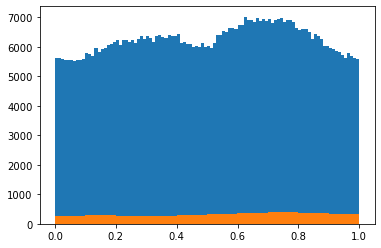

In [60]:
oklow=evtlist['PI']<=5.5*25
totonl=plt.hist(phdata[oklow],bins=100)
totonh=plt.hist(phdata[~oklow],bins=10)

Text(0.5, 0, 'Phase')

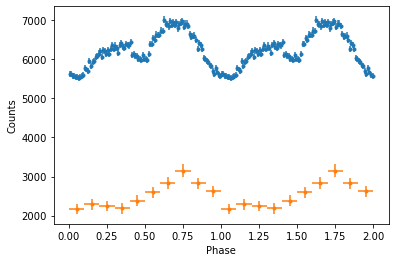

In [61]:
_ph=np.linspace(0,2,201)
plottwo(0.5*totonl[1][:-1]+0.5*totonl[1][1:],totonl[0],(totonl[0])**0.5,'.')
_ph=np.linspace(0,2,21)
plottwo(0.5*totonh[1][:-1]+0.5*totonh[1][1:],8*totonh[0],8*(totonh[0])**0.5,'.')

#plt.plot(_ph,cfunk(_ph,*cfit[0]))
plt.ylabel('Counts')
plt.xlabel('Phase')

In [62]:
ppp_rot_low=minimize(maxlikerotation2_ok,ppp_rot2.x,method='Nelder-Mead',args=(phdata[oklow],qdata[oklow],udata[oklow]))
ppp_rot_high=minimize(maxlikerotation2_ok,ppp_rot2.x,method='Nelder-Mead',args=(phdata[~oklow],qdata[~oklow],udata[~oklow]))

In [63]:
np.save("output/totonh.npy",totonh)
np.save("output/totonl.npy",totonl)
np.save('output/ppp_rot',(ppp_rot2,ppp_rot_low,ppp_rot_high))

/home/idies/miniconda3/envs/heasoft/lib/python3.8/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


0.13929014966290582 0.00713788746660365


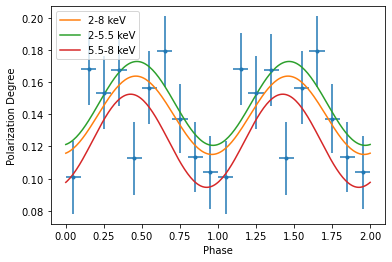

In [64]:
_ph=np.linspace(0,2,201)
plottwo((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.abs(np.tanh(ppp_phase.x[1::2])),ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2])**2,'.')
#plt.plot(_ph,cfunk(_ph,*pfit[0])/100)
plt.plot(_ph,np.abs(ppp_rot2.x[0]*(1+ppp_rot2.x[5]*np.cos(2*np.pi*(_ph-ppp_rot2.x[6])))),label='2-8 keV')
plt.plot(_ph,np.abs(ppp_rot_low.x[0]*(1+ppp_rot_low.x[5]*np.cos(2*np.pi*(_ph-ppp_rot_low.x[6])))),label='2-5.5 keV')
plt.plot(_ph,np.abs(ppp_rot_high.x[0]*(1+ppp_rot_high.x[5]*np.cos(2*np.pi*(_ph-ppp_rot_high.x[6])))),label='5.5-8 keV')
plt.ylabel('Polarization Degree')
plt.xlabel('Phase')
#plt.ylim(0.1,0.6)
plt.legend()
plt.savefig('figures/polar-deg-energy.pdf')
print(np.mean(np.abs(np.tanh(ppp_phase.x[1::2]))),np.sum((ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2]))**2)**0.5/10)


Alpha:                      0.000103414
Beta:                       -2.85502e-05
Mean Polarization Fraction: 0.138361
Pole across Line of Sight:  0.933985
Peak Flux:                  0.621717



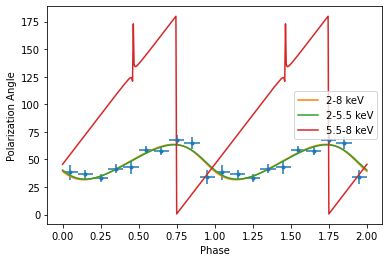

In [65]:
shift=0
plottwo((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.mod(np.degrees(np.where(ppp_phase.x[1::2]>0,0,np.pi*0.5)+ppp_phase.x[::2])-shift,180)+shift,np.degrees(ppp_phase_err[::2]),'.')
_ph=np.linspace(0,2,401)
print('''
Alpha:                      %g
Beta:                       %g
Mean Polarization Fraction: %g
Pole across Line of Sight:  %g
Peak Flux:                  %g
''' % (ppp_rot.x[1]%180,ppp_rot.x[2],np.abs(np.tanh(ppp_rot.x[0])),np.mod(ppp_rot.x[4]+(0 if ppp_rot.x[2]>0 else 0.5),1),
                                                            np.mod(cfit[0][1] if cfit[0][0]>0 else cfit[0][1]-0.5,1)))

if ppp_rot.x[0]>0:
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot.x[1],ppp_rot.x[2],_ph-ppp_rot.x[4])+np.radians(ppp_rot.x[3]-shift)),np.pi))+shift,label='2-8 keV')
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot_low.x[1],ppp_rot_low.x[2],_ph-ppp_rot_low.x[4])+np.radians(ppp_rot_low.x[3]-shift)),np.pi))+shift,label='2-5.5 keV')
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot_high.x[1],ppp_rot_high.x[2],_ph-ppp_rot_high.x[4])+np.radians(ppp_rot_high.x[3]-shift)),np.pi))+shift,label='5.5-8 keV')
else:
    plt.plot(_ph,np.degrees(np.mod(np.pi/2+(angfunk(ppp_rot.x[1],ppp_rot.x[2],_ph-ppp_rot.x[4])+np.radians(ppp_rot.x[3]-shift)),np.pi))+shift)

'''if ppp_rot2.x[0]>0:
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot2.x[1],ppp_rot2.x[2],_ph-ppp_rot2.x[4])+np.radians(ppp_rot2.x[3]-shift)),np.pi))+shift)
else:
    plt.plot(_ph,np.degrees(np.mod(np.pi/2+(angfunk(ppp_rot2.x[1],ppp_rot2.x[2],_ph-ppp_rot2.x[4])+np.radians(ppp_rot2.x[3]-shift)),np.pi))+shift)
    '''
#plt.ylim(25,75)
plt.ylabel('Polarization Angle')
plt.xlabel('Phase')
plt.legend()
plt.savefig('figures/polar-angle-energy.pdf')